In [ ]:
## thought up new way of handling NaNs - let's test it out.

In [2]:
from datetime import datetime, timedelta
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import scipy.stats as stats
import seaborn as sns
from sklearn import linear_model
from sklearn import metrics
from sklearn import preprocessing
from sklearn.cross_validation import train_test_split
from sklearn.pipeline import make_pipeline

import networkx as nx
from networkx.algorithms.components.connected import connected_components

%matplotlib notebook
%timeit

#show up to 100 columns and rows.
pd.set_option('display.max_columns', 100, 'display.max_rows', 100)

In [4]:
data_file = "theorem_model_variables_test.pkl"

## data appears to have been savied in Python 2 - changing encoding allows us to properly load data
with open(data_file, 'rb') as pickle_file:
    reduced_data = pickle.load(pickle_file, encoding='latin1') 

In [5]:
reduced_data.head()

,DolLoanAmountRequested,BorrowerRate,NumMonthsTerm,EnumListingCategory,DolMonthlyIncome,FracDebtToIncomeRatio,StrEmploymentStatus,StrOccupation,NumMonthsEmployed,NumPriorProsperLoansLatePayments,NumPriorProsperLoans61dpd,BoolIsLender,BoolInGroup,EnumChannelCode,NumTradesOpened6,NumOpenTradesDelinqOrPastDue6,DolTotalBalanceOnPublicRecords,NumRealEstateTrades,DolMonthlyDebt,NumCurrentDelinquencies,NumPublicRecordsLast10Years,NumPublicRecords12,DolAmountDelinquent,PctBankcardUtil,NumTotalInquiries,DaysSinceFirstCredit,Cancelled,BoolPriorProsperLoanee
ListingNumber,,,,,,,,,,,,,,,,,,,,,,,,,,,,
973605,15000.0,0.1620,60,1,6000.0000,0.27,Employed,Tradesman - Mechanic,445.0,NaN,NaN,0,False,70000,1,0,0,2,1242,0,0,0,0,0.97,5,13907,1,False
981099,15000.0,0.1585,60,1,7916.6667,0.35,Other,NaN,32.0,NaN,NaN,0,False,70000,1,0,0,2,2289,0,0,0,0,0.48,3,14244,1,False
1025766,4000.0,0.2085,36,1,2083.3333,0.53,Employed,Professional,4.0,0.0,NaN,0,False,80000,0,0,0,0,911,0,0,0,0,0.93,5,4152,0,True
1003835,10000.0,0.1299,36,13,3750.0000,0.14,Employed,Medical Technician,2.0,NaN,NaN,0,False,90000,1,0,0,0,223,0,0,0,0,0.26,1,2948,1,False
1011335,20000.0,0.1440,60,1,9000.0000,0.16,Employed,Executive,90.0,0.0,NaN,0,False,80000,1,0,1249,1,1264,1,2,0,0,0.81,17,8335,0,True


In [7]:
## which variables are NaN?
reduced_data.isnull().any()

DolLoanAmountRequested              False
BorrowerRate                        False
NumMonthsTerm                       False
EnumListingCategory                 False
DolMonthlyIncome                    False
FracDebtToIncomeRatio                True
StrEmploymentStatus                 False
StrOccupation                        True
NumMonthsEmployed                    True
NumPriorProsperLoansLatePayments     True
NumPriorProsperLoans61dpd            True
BoolIsLender                        False
BoolInGroup                         False
EnumChannelCode                     False
NumTradesOpened6                    False
NumOpenTradesDelinqOrPastDue6       False
DolTotalBalanceOnPublicRecords      False
NumRealEstateTrades                 False
DolMonthlyDebt                      False
NumCurrentDelinquencies             False
NumPublicRecordsLast10Years         False
NumPublicRecords12                  False
DolAmountDelinquent                 False
PctBankcardUtil                   

Already figured out how to deal with StrOccupation, FracDebtToIncomeratio and NumMonthsEmployed. 

Just need to handle NumPriorProsperLoansLatePayments and NumPriorProsperLoans61dpd            

In [9]:
print(reduced_data['NumPriorProsperLoansLatePayments'].value_counts())
print(reduced_data['NumPriorProsperLoans61dpd'].value_counts())

0.0     16138
1.0        68
2.0        25
3.0        13
4.0        10
5.0         6
7.0         6
6.0         6
9.0         6
13.0        3
8.0         3
25.0        2
10.0        2
11.0        1
Name: NumPriorProsperLoansLatePayments, dtype: int64
1.0    47
2.0     3
Name: NumPriorProsperLoans61dpd, dtype: int64


NumPriorProsperLoans61dpd is only non-NaN if greater than 1, even though very rare. Should probably change behavior to get real predictivity.

The big challenge is that non-NaN NumPriorProsperLoansLatePayments means that you are a prior user, and therefore much less liekly to cancel than the general population. But if we plug in 0 or the mean for NaNs, then we completely mess up the regression.

My new strategy for dealing with NaNs - drop all the NaN rows and perform a fit, then give a mock value to the NaN rows that leaves the regression coefficients unchanged.

In [17]:
reduced_data['BoolPriorProsperLoanee'].value_counts()

False    236180
True      16289
Name: BoolPriorProsperLoanee, dtype: int64

In [34]:
data_nan = reduced_data[['NumPriorProsperLoansLatePayments','Cancelled']]
data_nan.dropna(inplace = True)
print(data_nan)

               NumPriorProsperLoansLatePayments  Cancelled
ListingNumber                                             
1025766                                     0.0          0
1011335                                     0.0          0
1029573                                     0.0          0
1013984                                     0.0          0
1020431                                     0.0          0
1036179                                     0.0          1
1038345                                     0.0          0
1042284                                     0.0          0
1061826                                     0.0          0
1037213                                     0.0          0
1072737                                     0.0          0
1028164                                     0.0          0
975100                                      0.0          0
1078564                                     0.0          1
1082725                                     0.0         

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [37]:
y = data_nan['Cancelled']
X = data_nan['NumPriorProsperLoansLatePayments'].to_frame()

mm = linear_model.LogisticRegression()
mm.fit(X,y)
print(mm.coef_)

[[ 0.05216433]]


In [54]:
mm.predict_proba(10)

array([[ 0.79385203,  0.20614797]])

<IPython.core.display.Javascript object>


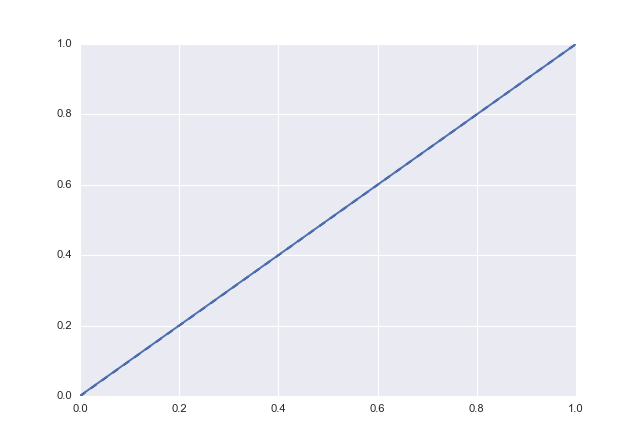

[[ 0.03231427]]


//anaconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


In [40]:
variables = [['NumPriorProsperLoansLatePayments']]

y = data_nan['Cancelled']
X = []
X_train = []
X_test = []
y_train = []
y_test = []

fig, ax = plt.subplots()
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')

for i,v in enumerate(variables):
    standard_scaler = preprocessing.StandardScaler()
    X.append(standard_scaler.fit_transform(data_nan[v]))
    X_tr, X_te, y_tr, y_te = train_test_split(X[i], y, test_size=0.3, random_state=0)
    logm = linear_model.LogisticRegression()
    logm.fit(X_tr,y_tr)
    probs = logm.predict_proba(X_te)
    #print(probs[:20])
    fpr, tpr, thresholds = metrics.roc_curve(y_te,probs[:,1])
    plt.plot(fpr,tpr)
    plt.legend()
    print(logm.coef_)

In [48]:
probs[data_nan['NumPriorProsperLoansLatePayments'] == 15]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
  if __name__ == '__main__':


array([[ 0.86424248,  0.13575752],
       [ 0.86424248,  0.13575752],
       [ 0.86424248,  0.13575752],
       ..., 
       [ 0.86424248,  0.13575752],
       [ 0.86424248,  0.13575752],
       [ 0.86424248,  0.13575752]])

In [50]:
aa = range(len(data_nan))
aa[data_nan['NumPriorProsperLoansLatePayments'] == 1]

TypeError: range indices must be integers or slices, not Series

In [ ]:
#NumInquiries6', 'NumInquiries6MinusLastTwoWeeks', 'NumTotalInquiries